In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from wordcloud import WordCloud
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import naive_bayes
%matplotlib inline

In [4]:
train=pd.read_csv("train_E6oV3lV.csv")
test=pd.read_csv('test_tweets_anuFYb8.csv')

In [5]:
print train.head()
print train.shape

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
(31962, 3)


In [6]:
print test.head()
test.shape

      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...


(17197, 2)

In [7]:
data=train.append(test)

In [8]:
print data.head()
data.shape

   id  label                                              tweet
0   1    0.0   @user when a father is dysfunctional and is s...
1   2    0.0  @user @user thanks for #lyft credit i can't us...
2   3    0.0                                bihday your majesty
3   4    0.0  #model   i love u take with u all the time in ...
4   5    0.0             factsguide: society now    #motivation


(49159, 3)

In [9]:
# Data Preprocessing

In [10]:
# Removing the @user in every tweet, so as to make it clean
regex=r"@[\w]*"
def _remove_regex(input_text, regex_pattern):
    username = re.finditer(regex_pattern, input_text) 
    for i in username: 
        input_text = re.sub(i.group().strip(), '', input_text)
    return input_text


In [11]:
data['tweet']=np.vectorize(_remove_regex)(data['tweet'],regex)

In [12]:
# Decode the tweets
data['tweet']=data['tweet'].apply(lambda x:x.decode('utf8').encode('ascii','ignore'))

In [13]:
# Remove Stopwords
noise_list=set(stopwords.words('english'))
def _remove_noise(input_text):
    words = input_text.split() 
    noise_free_words = [word for word in words if word not in noise_list] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

In [14]:
data['tweet']=np.vectorize(_remove_noise)(data['tweet'])

In [15]:
data['tweet'] = data['tweet'].str.replace("[^a-zA-Z#]", " ")

In [16]:
data['tweet']=data['tweet'].apply(lambda x:" ".join([w for w in x.split() if len(w)>3]))

In [17]:
ps=PorterStemmer()
wnl=WordNetLemmatizer()

In [18]:
data['tweet']=data['tweet'].apply(lambda x: [w for w in x.split(' ')])

In [19]:
data['tweet']=data['tweet'].apply(lambda x:(' ').join([ps.stem(w) for w in x]))

In [20]:
data['tweet']=data['tweet'].apply(lambda x: [w for w in x.split(' ')])

In [21]:
data['tweet']=data['tweet'].apply(lambda x:(' ').join([wnl.lemmatize(w) for w in x]))

In [22]:
#Data Visualization

In [23]:
z=data['tweet'].apply(lambda x:[w for w in x.split()])

In [24]:
all_words=(" ").join(text for text in data['tweet'])

In [25]:
wordcloud=WordCloud(width=500,height=300,random_state=21).generate(all_words)

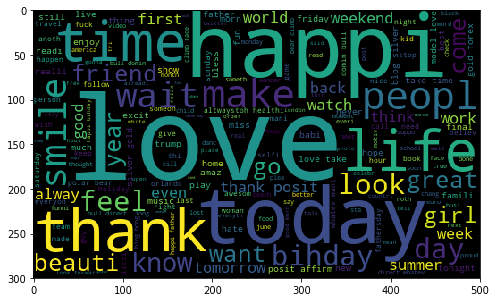

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)


In [27]:
nega_words=(" ").join(w for w in data['tweet'][data['label']==1])

In [28]:
nega_cloud=WordCloud(width=500,height=300,random_state=21).generate(nega_words)

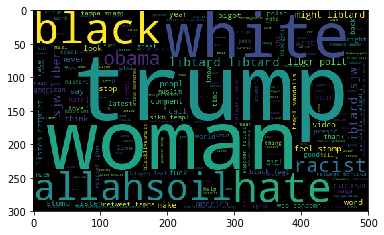

In [29]:
plt.imshow(nega_cloud)
plt.show()

In [30]:
normal_words=(" ").join(w for w in data['tweet'][data['label']==0])


In [31]:
normal_cloud=WordCloud(width=500,height=300,random_state=21).generate(normal_words)

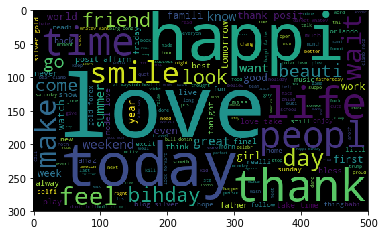

In [32]:
plt.imshow(normal_cloud)
plt.show()

In [33]:
def _hashtag(input_text):
    hashtag=[]
    for i in input_text:
        word=re.findall(r"#[\w]*",i)
        hashtag.append(word)
    return hashtag

In [34]:
HT_negative= _hashtag(data['tweet'][data['label']==1])

In [35]:
HT_negative=sum(HT_negative,[])

In [36]:
HT_positive=_hashtag(data['tweet'][data['label']==0])

In [37]:
HT_positive=sum(HT_positive,[])

In [38]:
a=nltk.FreqDist(HT_positive)

In [39]:
d=pd.DataFrame({'Hashtag': list(a.keys()),'Count':list(a.values())})

In [40]:
d=d.nlargest(columns='Count',n=10)

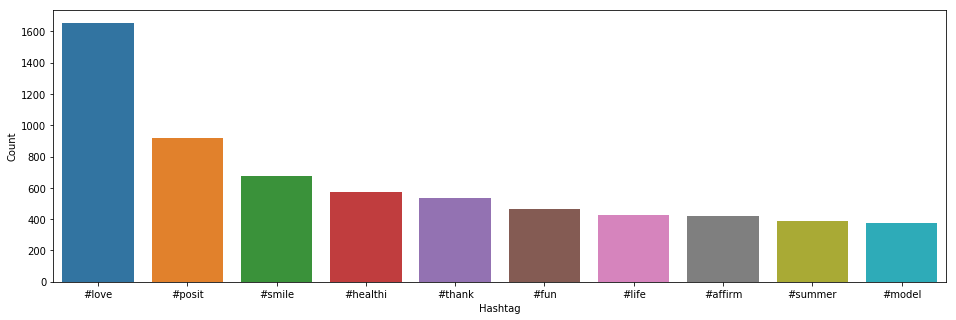

In [41]:
plt.figure(figsize=(16,5))
ax=sns.barplot(data=d,x='Hashtag',y='Count')
ax.set(ylabel='Count')
plt.show()

In [42]:
b=nltk.FreqDist(HT_negative)

In [43]:
e=pd.DataFrame({'Hashtag':list(b.keys()),'Count':list(b.values())})

In [44]:
e=e.nlargest(columns='Count',n=10)

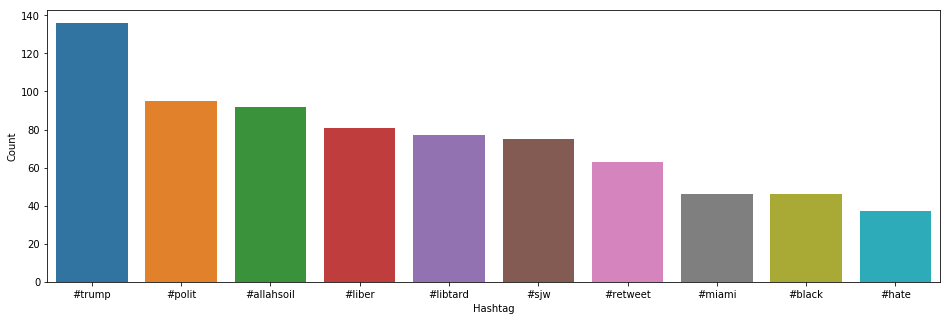

In [45]:
plt.figure(figsize=(16,5))
ax=sns.barplot(data=e,x='Hashtag',y='Count')
ax.set(ylabel='Count')
plt.show()

In [46]:
# Now, word is to be convert into vectors to fit the model

In [79]:
cv=CountVectorizer(max_df=0.95,min_df=3,max_features=7500,ngram_range=(1,2))

In [80]:
cvtrain=cv.fit_transform(data['tweet'])

In [81]:
train_cv=cvtrain[:31962]
test_cv=cvtrain[31962:]

In [82]:
x_train,y_train,x_test,y_test=train_test_split(train_cv,train['label'],test_size=0.3,random_state=21)

In [83]:
clsvm=svm.SVC(kernel='linear',C=0.77)

In [84]:
clsvm.fit(x_train,x_test)

SVC(C=0.77, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
pred=clsvm.predict(y_train)

In [86]:
f1_score(y_test,pred)

0.6563011456628479

In [87]:
sub=clsvm.predict(test_cv)

In [68]:
test['label']=sub

In [69]:
submission=test[['id','label']]

In [70]:
submission.to_csv('subm34.csv',index=False)